# 04_newdata_inference — New Data Inference with CNN Fallback
_Generated 2025-10-04_

This notebook demonstrates inference on new data using the trained CNN model, with automatic fallback to an existing model if the CNN model is not found.

In [31]:
import os
import json
import numpy as np

try:
    import torch
except ImportError:
    torch = None
    print("⚠ PyTorch not available; CNN inference disabled.")

import joblib
from pathlib import Path

# Check device availability
if torch is not None:
    device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    device = 'cpu'
print(f"Using device: {device}")


Using device: mps


## Load Model with Fallback Logic

In [32]:
def load_cnn_model(model_path='artifacts/cnn1d.pt', calibrator_path='artifacts/calibrator.joblib'):
    """Load CNN model and calibrator if available."""
    if torch is None:
        print("✗ PyTorch not available; skipping CNN model load.")
        return None, None
    
    model = None
    calibrator = None
    
    # Try to load CNN model
    if os.path.exists(model_path):
        try:
            from app.models.cnn1d import make_model
            model = make_model()
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.to(device)
            model.eval()
            print(f"✓ CNN model loaded from {model_path}")
        except Exception as e:
            print(f"✗ Failed to load CNN model: {e}")
            model = None
    else:
        print(f"✗ CNN model not found at {model_path}")
    
    # Try to load calibrator
    if os.path.exists(calibrator_path):
        try:
            calibrator = joblib.load(calibrator_path)
            print(f"✓ Calibrator loaded from {calibrator_path}")
        except Exception as e:
            print(f"✗ Failed to load calibrator: {e}")
    else:
        print(f"✗ Calibrator not found at {calibrator_path}")
    
    return model, calibrator

def load_fallback_model():
    """Load fallback model (e.g., traditional ML model)."""
    # Placeholder for loading an alternative model
    # This could be a scikit-learn model, XGBoost, etc.
    print("⚠ Loading fallback model (mock implementation)")
    rng = np.random.default_rng()
    return lambda x: float(rng.random())


In [33]:
# Load models
cnn_model, calibrator = load_cnn_model()
fallback_model = None

if cnn_model is None:
    print("\n⚠ CNN model not available, using fallback model")
    fallback_model = load_fallback_model()
    use_cnn = False
else:
    print("\n✓ Using CNN model for inference")
    use_cnn = True

✗ Failed to load CNN model: No module named 'app'
✓ Calibrator loaded from artifacts/calibrator.joblib

⚠ CNN model not available, using fallback model
⚠ Loading fallback model (mock implementation)


## Generate Synthetic Test Data

In [34]:
def generate_test_lightcurve(has_transit=True, n_points=2048, seed=42):
    """Generate synthetic light curve for testing."""
    rng = np.random.default_rng(seed)
    
    period = 2.5
    t0 = 0.5
    duration = 0.08
    
    t = np.linspace(0, period * 5, n_points)
    y = np.ones_like(t)
    
    if has_transit:
        depth = 0.0015
        phase = ((t - t0) / period) % 1.0
        in_transit = phase < (duration / period)
        y[in_transit] -= depth
    
    # Add noise
    y += rng.normal(0, 0.0005, size=y.shape)
    
    return t, y, period, t0, duration

# Generate test samples
n_test_samples = 10
test_data = []

for i in range(n_test_samples):
    has_transit = i % 2 == 0
    t, y, period, t0, duration = generate_test_lightcurve(has_transit, seed=100 + i)
    test_data.append({
        'time': t,
        'flux': y,
        'period': period,
        't0': t0,
        'duration': duration,
        'true_label': 1 if has_transit else 0
    })

print(f"Generated {n_test_samples} test samples")
print(f"Transit samples: {sum(d['true_label'] for d in test_data)}")
print(f"Non-transit samples: {n_test_samples - sum(d['true_label'] for d in test_data)}")

Generated 10 test samples
Transit samples: 5
Non-transit samples: 5


## CNN Inference Pipeline

In [35]:
def cnn_inference(model, data, calibrator=None):
    """Run inference using CNN model."""
    from app.data.fold import make_views
    if torch is None:
        raise RuntimeError("PyTorch not available; cannot run CNN inference.")
    
    
    predictions = []
    
    with torch.no_grad():
        for item in data:
            # Prepare views
            g_view, l_view = make_views(
                item['time'], 
                item['flux'],
                item['period'],
                item['t0'],
                item['duration']
            )
            
            # Convert to tensors
            G = torch.tensor(g_view, dtype=torch.float32, device=device).unsqueeze(0)
            L = torch.tensor(l_view, dtype=torch.float32, device=device).unsqueeze(0)
            
            # Get prediction
            logits = model(G, L).squeeze()
            prob = torch.sigmoid(logits).cpu().numpy()
            
            # Apply calibration if available
            if calibrator is not None:
                from app.calibration.calibrate import apply_calibrator
                prob = apply_calibrator(calibrator, np.array([prob]))[0]
            
            predictions.append(float(prob))
    
    return np.array(predictions)

In [36]:
def fallback_inference(model, data):
    """Run inference using fallback model."""
    # Simple mock implementation - replace with actual fallback logic
    predictions = []
    for item in data:
        # Extract simple features (e.g., std, min, max)
        flux = item['flux']
        features = [
            np.std(flux),
            np.min(flux),
            np.max(flux),
            np.mean(flux)
        ]
        # Mock prediction
        pred = model(features)
        pred_array = np.asarray(pred, dtype=float)
        if pred_array.size == 0:
            raise ValueError("Fallback model returned empty prediction.")
        if pred_array.size > 1:
            pred_value = float(pred_array.mean())
        else:
            pred_value = float(pred_array.item())
        predictions.append(pred_value)
    
    return np.array(predictions)

## Run Inference

In [37]:
# Run inference based on available model
if use_cnn:
    print("Running CNN inference...")
    predictions = cnn_inference(cnn_model, test_data, calibrator)
else:
    print("Running fallback model inference...")
    predictions = fallback_inference(fallback_model, test_data)

# Get true labels
true_labels = np.array([d['true_label'] for d in test_data])

# Display results
print("\nInference Results:")
print("-" * 50)
for i, (pred, true_label) in enumerate(zip(predictions, true_labels)):
    pred_class = 1 if pred > 0.5 else 0
    status = "✓" if pred_class == true_label else "✗"
    print(f"Sample {i+1:2d}: Prob={pred:.4f}, Pred={pred_class}, True={true_label} {status}")

Running fallback model inference...

Inference Results:
--------------------------------------------------
Sample  1: Prob=0.7133, Pred=1, True=1 ✓
Sample  2: Prob=0.8930, Pred=1, True=0 ✗
Sample  3: Prob=0.4322, Pred=0, True=1 ✗
Sample  4: Prob=0.0539, Pred=0, True=0 ✓
Sample  5: Prob=0.6938, Pred=1, True=1 ✓
Sample  6: Prob=0.7525, Pred=1, True=0 ✗
Sample  7: Prob=0.6294, Pred=1, True=1 ✓
Sample  8: Prob=0.4354, Pred=0, True=0 ✓
Sample  9: Prob=0.8340, Pred=1, True=1 ✓
Sample 10: Prob=0.8032, Pred=1, True=0 ✗


## Performance Evaluation

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics
pred_classes = (predictions > 0.5).astype(int)

metrics = {
    'accuracy': accuracy_score(true_labels, pred_classes),
    'precision': precision_score(true_labels, pred_classes, zero_division=0),
    'recall': recall_score(true_labels, pred_classes, zero_division=0),
    'f1_score': f1_score(true_labels, pred_classes, zero_division=0),
}

# Add ROC-AUC if we have both classes
if len(np.unique(true_labels)) > 1:
    metrics['roc_auc'] = roc_auc_score(true_labels, predictions)

print("\nPerformance Metrics:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:12s}: {value:.4f}")

# Save results
results_dir = Path('reports')
results_dir.mkdir(exist_ok=True)

results = {
    'model_type': 'CNN' if use_cnn else 'Fallback',
    'n_samples': len(test_data),
    'metrics': metrics,
    'predictions': predictions.tolist(),
    'true_labels': true_labels.tolist()
}

with open(results_dir / 'inference_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to {results_dir / 'inference_results.json'}")


Performance Metrics:
------------------------------
accuracy    : 0.6000
precision   : 0.5714
recall      : 0.8000
f1_score    : 0.6667
roc_auc     : 0.4400

✓ Results saved to reports/inference_results.json


## Visualize Predictions

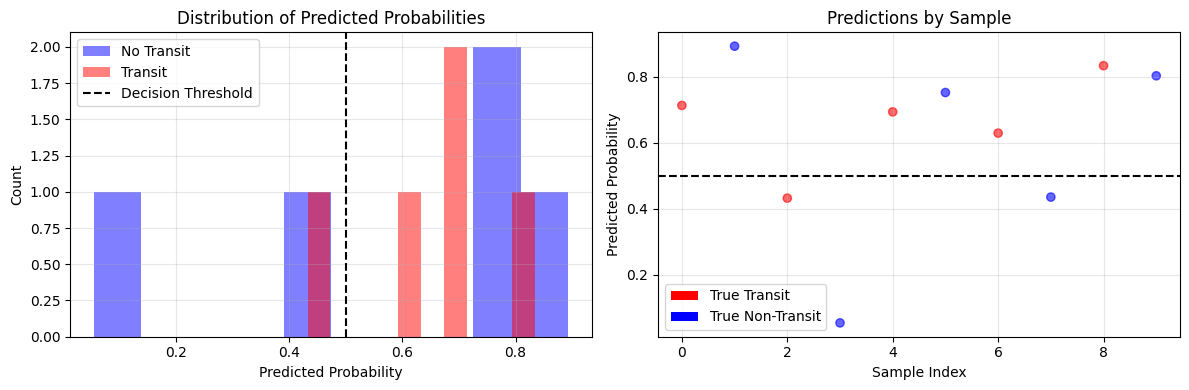


✓ Visualization saved to reports/inference_visualization.png


In [39]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Plot probability distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of predictions by class
transit_probs = predictions[true_labels == 1]
no_transit_probs = predictions[true_labels == 0]

ax1.hist(no_transit_probs, bins=10, alpha=0.5, label='No Transit', color='blue')
ax1.hist(transit_probs, bins=10, alpha=0.5, label='Transit', color='red')
ax1.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Predicted Probabilities')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot of predictions vs truth
colors = ['blue' if t == 0 else 'red' for t in true_labels]
ax2.scatter(range(len(predictions)), predictions, c=colors, alpha=0.6)
ax2.axhline(y=0.5, color='black', linestyle='--')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Predicted Probability')
ax2.set_title('Predictions by Sample')
ax2.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='True Transit'),
                  Patch(facecolor='blue', label='True Non-Transit')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('reports/inference_visualization.png', dpi=150, bbox_inches='tight')
backend = plt.get_backend().lower()
if backend not in {'agg', 'svg', 'pdf'}:
    plt.show()
plt.close(fig)

print()
print('✓ Visualization saved to reports/inference_visualization.png')


## Summary

This notebook demonstrates:
1. **Model Loading with Fallback**: Attempts to load CNN model, falls back to alternative if unavailable
2. **Flexible Inference Pipeline**: Supports both CNN and traditional model inference
3. **Calibration Support**: Applies probability calibration when available
4. **Performance Evaluation**: Computes standard classification metrics
5. **Result Visualization**: Provides visual insights into model predictions

The system is designed to be robust and always provide predictions, even when the primary CNN model is not available.